# Design and Dynamics of AES Block Cipher

## Introduction

In [4]:
from aes import AES
from diffusion_confusion import flip_bit, hamming_distance
from diffusion_confusion import aes_diffusion, aes_confusion
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

## AES

**Advanced Encryption Standard** (AES) is a specification for symmetric-key encryption. 
This standard is made of three block ciphers and each one of them contains a key expansion and a datapath considered as iterated block cipher, an iteration is called "round".
In this document it is considered the Block cipher with 128 bit-length key, whit 10 rounds.

In [2]:
# AES class test
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]
aes = AES(key)

## Add Round Key

**Add_round_key** is a "key-addition" layer that performs a bit-wise XOR between the current _state_ and the given _round-key_ (𝐵𝑗 = 𝐴𝑗 ⨁ 𝐾𝑗). It's used to introduce the secret key into the encryption process, in order to make an output dependent on the key.

In [3]:
# add_round_key test
state = [207, 96, 151, 113, 158, 50, 233, 189, 188, 254, 199, 230, 105, 134, 130, 141]
round_key = [[0x2b, 0x7e, 0x15, 0x16], [0x28, 0xae, 0xd2, 0xa6], [0xab, 0xf7, 0x15, 0x88], [0x09, 0xcf, 0x4f, 0x3c]]
add_state = aes.add_round_key(state, round_key)
print(add_state)

[228, 30, 130, 103, 182, 156, 59, 27, 23, 9, 210, 110, 96, 73, 205, 177]


## Substitution Bytes

**Byte_substitution** is a non-linear layer that applies the AES S-box substitution to each byte of the _state_, using a look-up table(LUT). It's used to provide ***confusion*** to the cipher.

Note: Every single byte is replaced using the Rijndael S-box LUT.

In [4]:
# byte_substitution test
print(state)
sub_state = aes.byte_substitution(state)
print(sub_state)

[228, 30, 130, 103, 182, 156, 59, 27, 23, 9, 210, 110, 96, 73, 205, 177]
[105, 114, 19, 133, 78, 222, 226, 175, 240, 1, 181, 159, 208, 59, 189, 200]


## Shift Rows

**Shift_rows** is a linear mixing layer that cyclically shift the rows of the AES state matrix(4x4):
- Row 0: unchanged;
- Row 1: shifted left by 1 byte;
- Row 2: shifted left by 2 bytes;
- Row 3: shifted left by 3 bytes;

This layer is used to provide ***diffusion*** by repositioning the bytes across the _state_.

In [19]:
# shift_rows test
curr_state_matrix = np.array(state).reshape((4,4)).T
shift_state = aes.shift_rows(state)
shift_state_matrix = np.array(shift_state).reshape((4,4)).T

print(f"Current state matrix:\n", curr_state_matrix)
print(f"\nShifted matrix:")
print(shift_state_matrix)

Current state matrix:
 [[105  78 240 208]
 [114 222   1  59]
 [ 19 226 181 189]
 [133 175 159 200]]

Shifted matrix:
[[105  78 240 208]
 [222   1  59 114]
 [181 189  19 226]
 [200 133 175 159]]


## Mix Columns

**Mix_column** is the layer that applies a linear transformation to each column of the state. Basically it's a matrix-vector multiplication over the finite $GF(2^{8})$ using a fixed matrix and an irreducible polynomial:

$P(x) = x^8 + x^4 + x^3 + x + 1$

The following optimization tricks allow implementation with simple bit operations: ***shift + xor***.
Only the constants 01, 02, and 03 are used in multiplication:
- Multiplying by **01**: identity (just return the byte);
- Multiplying by **02**: If MSB is 0 → left shift by 1, otherwise if MSB is 1 → left shift by 1 and XOR with 0x1b (which is the modulo reduction for 𝑃(𝑥));
- Multiplying by **03**: equivalent to (02*byte) XOR byte;

The purpose of this layer is to enhance ***diffusion*** by combinig the bytes within each column.

In [6]:
# mix_columns test
print(state)
mix_state = aes.mix_column(state)
print(mix_state)

[105, 114, 19, 133, 78, 222, 226, 175, 240, 1, 181, 159, 208, 59, 189, 200]
[210, 61, 169, 203, 168, 123, 165, 171, 210, 169, 58, 154, 131, 178, 201, 102]


## Key Expansion

**Key_expansion** it's an important function that generates all $𝑁_𝑟+1$ _round-keys_ from the initial 128-bit cipher key(with $N_r = 10$ as number of rounds + 1 initial).

Each AES round (stage 𝑖) generates the next round key
($𝐾_𝑖$) from the previous ($𝐾_𝑖 − 1$) using a separate key delivered from the original one.
Round keys are generated word-wise where each word consists
of 4 bytes.
If the key is $𝑁_𝑘$ words long, the key expansion is organized in
stages so that each stage generate $𝑁_𝑘$ words ($N_k = 4$, for a 128 bit-key).
Every stage implements a very similar transformation in which the only difference is in the round coefficient(RC).

In [27]:
k_exp = aes.key_expansion()
print(f"Expansion of 128-bit cipher key:\n")
pprint(k_exp)

Expansion of 128-bit cipher key:

[[[43, 126, 21, 22],
  [40, 174, 210, 166],
  [171, 247, 21, 136],
  [9, 207, 79, 60]],
 [[160, 250, 254, 23],
  [136, 84, 44, 177],
  [35, 163, 57, 57],
  [42, 108, 118, 5]],
 [[242, 194, 149, 242],
  [122, 150, 185, 67],
  [89, 53, 128, 122],
  [115, 89, 246, 127]],
 [[61, 128, 71, 125],
  [71, 22, 254, 62],
  [30, 35, 126, 68],
  [109, 122, 136, 59]],
 [[239, 68, 165, 65],
  [168, 82, 91, 127],
  [182, 113, 37, 59],
  [219, 11, 173, 0]],
 [[212, 209, 198, 248],
  [124, 131, 157, 135],
  [202, 242, 184, 188],
  [17, 249, 21, 188]],
 [[109, 136, 163, 122],
  [17, 11, 62, 253],
  [219, 249, 134, 65],
  [202, 0, 147, 253]],
 [[78, 84, 247, 14],
  [95, 95, 201, 243],
  [132, 166, 79, 178],
  [78, 166, 220, 79]],
 [[234, 210, 115, 33],
  [181, 141, 186, 210],
  [49, 43, 245, 96],
  [127, 141, 41, 47]],
 [[172, 119, 102, 243],
  [25, 250, 220, 33],
  [40, 209, 41, 65],
  [87, 92, 0, 110]],
 [[208, 20, 249, 168],
  [201, 238, 37, 137],
  [225, 63, 12, 200],

## Encryption

The **Enrypt** function takes a 16 bytes plaintext(fixed lenght) as input, and permforms encryption by using the AES algorithm.
As output will retrieve a byte string ciphertext. 

In [8]:
# encrypt test
plaintext1 = b'Bologna Campione'
ciphertext1 = aes.encrypt(plaintext1)
print(ciphertext1)
new_plaintext1 = aes.decrypt(ciphertext1)
print(new_plaintext1)

b'\x19Z\xf5\xa9t\x17`\x14ju\xbd\xba\xae\x94gD'
b'Bologna Campione'


## AES Diffusion and Confusion

This section it's important to evaluate how well the AES encryption function achieves diffusion and confusion, by observing how small changes in input affect the output ciphertext.

For both properties the procedure is the same, apart from the flip-bit operation, that changes plaintext (for Diffusion) or key (for Confusion).

- Generate a random plaintext x and key k;
- Flip 1 bit;
- Encrypt both: y = AES_k(x) and y' = AES_k(x');
- Compute the Hamming distance d(y, y');

#### ***DIFFUSION***
A cipher has strong diffusion if a single-bit change in the plaintext causes many bits in the ciphertext to change.
As a result, a distribution of Hamming distances centered around half the block size (64 bits) is expected.

In [28]:
# AES DIFFUSION Hamming Distance test
diff = aes_diffusion(num_rounds=10)  # otherwise "None" for complete encryption
print("Diffusion test – Hamming distance:", diff)

Diffusion test – Hamming distance: 66


#### ***CONFUSION***
A cipher has strong confusion if a single-bit change in the key causes many bits in the ciphertext to change.
Clearly, high Hamming distance means every output bit should depend on multiple key bits.

In [29]:
# AES CONFUSION Hamming Distance test
conf = aes_confusion(num_rounds=10)
print("Confusion test – Hamming distance:", conf)

Confusion test – Hamming distance: 59


### Monte Carlo Simulation

The Monte Carlo Simulation is a technique used to observe statistical behavior of the Hamming distances distribution.
The goal is to repeat the diffusion and confusion experiments many times with random inputs, then collect the distribution of Hamming distances.
This helps assess the average and spread of output differences.

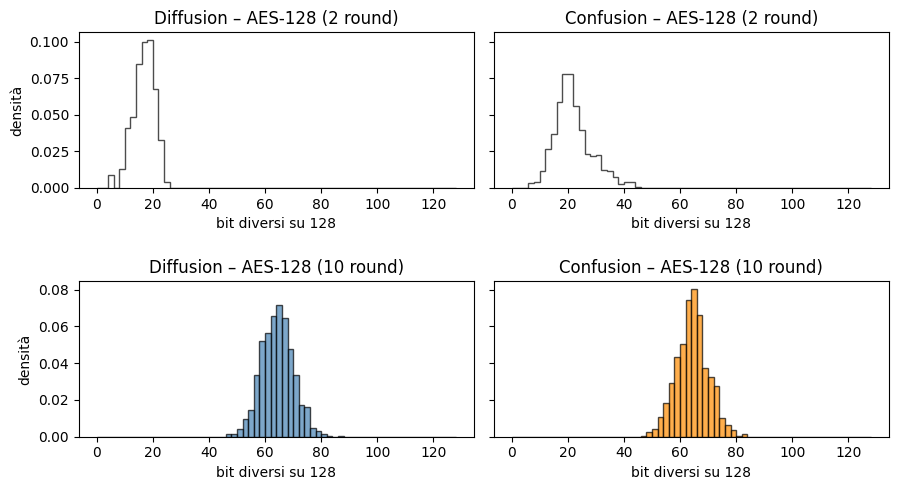

In [31]:
N_TRIALS = 800

# --- Monte Carlo ---------------------------------------------------------
diff_samples_2  = [aes_diffusion(2)  for n in range(N_TRIALS)]
conf_samples_2  = [aes_confusion(2)  for n in range(N_TRIALS)]

diff_samples_10 = [aes_diffusion(10)  for n in range(N_TRIALS)]
conf_samples_10 = [aes_confusion(10)  for n in range(N_TRIALS)]

# --- Plot side-by-side ---------------------------------------------------
bins = range(0, 129, 2)     # 0-128 bit, passo 2

fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharey='row')

axes[0, 0].hist(diff_samples_2, bins=bins, density=True, alpha=0.7, color='steelblue', edgecolor='black', histtype='step')
axes[0, 0].set_title("Diffusion – AES-128 (2 round)")
axes[0, 0].set_xlabel("bit diversi su 128")
axes[0, 0].set_ylabel("densità")

axes[0, 1].hist(conf_samples_2, bins=bins, density=True, alpha=0.7, color='darkorange', edgecolor='black', histtype='step')
axes[0, 1].set_title("Confusion – AES-128 (2 round)")
axes[0, 1].set_xlabel("bit diversi su 128")

axes[1, 0].hist(diff_samples_10, bins=bins, density=True, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].set_title("Diffusion – AES-128 (10 round)")
axes[1, 0].set_xlabel("bit diversi su 128")
axes[1, 0].set_ylabel("densità")

axes[1, 1].hist(conf_samples_10, bins=bins, density=True, alpha=0.7, color='darkorange', edgecolor='black')
axes[1, 1].set_title("Confusion – AES-128 (10 round)")
axes[1, 1].set_xlabel("bit diversi su 128")

fig.tight_layout()
fig.subplots_adjust(hspace=0.6)
plt.show()

PARTIALLY ENCRYPT

encrypt AES =! encrypt block cipher

## Modes of operation

### Electronic Codebook (ECB)

Mode that splits plaintext into 16-byte blocks and encrypts each block independently.
It is simple and parallelizable, but in case of identical plaintext blocks produce identical ciphertext blocks, which is not semantically secure.

### Cipher Block Chaining (CBC)
Mode that XORs each plaintext block with the previous ciphertext block and then encrypts the result.
It is more secure than ECB and it hides plaintext patterns. On the other hand it's not parallelizable for encryption and needs Initialization Vector(IV) and full decryption chain for random access.

$C_i = Enc(P_i ⊕ C_{i-1})$

### Cipher Feedback (CFB)

Mode that encrypts the previous ciphertext (or IV for first block), and XORs the output with the plaintext.
It can be used as a stream cipher(bit/byte feedback) and is self-synchronizing, but is slightly less efficient due to feedback chaining.

$C_i = P_i ⊕ Enc(C_{i-1})$

### Output Feedback (OFB)

Mode that encrypt the previous keystream block(starting from IV) then XORs with the plaintext. The keystream is independent of plaintext/ciphertext.
In this mode the keystream is fully precomputable and errors do not propagate.
The disadvantage is that keystream reuse is catastrophic.

$K_i = Enc(K_{i-1}),    C_i = P_i ⊕ K_i$


## Conclusion

The experiments confirm that the AES cipher exhibits strong diffusion and confusion properties. When a single bit is flipped in the plaintext or key:

- The average **Hamming distance** between ciphertexts is consistently centered around **64 bits**, which is exactly half of the 128-bit block size — a hallmark of ideal diffusion.
- Both diffusion and confusion evolve and amplify progressively across rounds, reaching maximum entropy after the final round.
- Monte Carlo simulations validate that this behavior is consistent across random inputs and not specific to certain plaintext-key pairs.

These results illustrate that AES successfully hides patterns in the plaintext and obscures relationships with the key, fulfilling critical cryptographic requirements. The encryption function's internal structure — particularly the S-box, ShiftRows, MixColumns, and AddRoundKey operations — collectively contribute to its strength against attacks.

Therefore, AES Block Cipher remains a reliable standard for symmetric encryption, highlighting the desired theoretical properties in practical implementations.


paper FIPS-197.pdf

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e41f3657-3455-4db1-9261-9e3fe3459d95' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>